In [1]:
dir_data = '../data'

In [2]:
import sys
sys.path.append('../')

from suncapturer.utils import standardize_time

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


## 데이터 불러오기
1. `gens.csv`
- 광명시 태양광 발전소(용량 472.39kW) 발전량 데이터 3개월치 (2022년 7월 21일 ~)
    - 모듈 경사일사량계, 모듈 표면 온도계 5분 주기 원본 데이터 포함 -> `envs.csv`
- 국내 타 지역 20개 태양광 발전소 발전량 데이터 2년치 (2020년 10월 1일 ~ 2022년 10월 23일)

2. `weathers.csv`, `forecast.csv`
- 발전소 별 인근 기상관측소에 대한 3가지 종류의 기상 실측/예측 데이터
- 발전소 별 인근 기상청 종관기상관측소 번호

In [3]:
gens = pd.read_csv(os.path.join(dir_data, 'gens.csv'))
envs = pd.read_csv(os.path.join(dir_data, 'envs.csv'))

fcst1 = pd.read_csv(os.path.join(dir_data, 'forecasts1.csv'))
fcst2 = pd.read_csv(os.path.join(dir_data, 'forecasts2.csv'))
fcst3 = pd.read_csv(os.path.join(dir_data, 'forecasts3.csv'))

weather1 = pd.read_csv(os.path.join(dir_data, 'weathers1.csv'))
weather2 = pd.read_csv(os.path.join(dir_data, 'weathers2.csv'))
weather3 = pd.read_csv(os.path.join(dir_data, 'weathers3.csv'))


## 중간 중간 사용할 변수 및 함수

In [4]:
start  = '2020-10-01 00:00:00'
start0 = '2022-07-21 00:00:00'
end    = '2022-10-23 23:00:00'

t  = pd.date_range(start , end, freq='1H')
t0 = pd.date_range(start0, end, freq='1H')

print(len(t), len(t0))

18072 2280


## `gens.csv`
발전소별 발전량, id=0이 광명시 태양광 발전소, id=1~20: 타 지역 발전소 과거 데이터
- `id`: 해당 발전소의 id
- `time`: 발전 시간.  2021-06-01 01:00:00 은 2021-06-01 00:00:00 ~ 2021-06-01 00:59:59 까지의 시간을 나타낸다.
- `amount`: Float (발전량, kWh)

In [5]:
gens

,id,time,amount
0,0,2022-07-21 01:00:00+09:00,0.000
1,0,2022-07-21 02:00:00+09:00,0.000
2,0,2022-07-21 03:00:00+09:00,0.000
3,0,2022-07-21 04:00:00+09:00,0.000
4,0,2022-07-21 05:00:00+09:00,0.000
...,...,...,...
363702,20,2022-10-23 20:00:00+09:00,0.008
363703,20,2022-10-23 21:00:00+09:00,0.008
363704,20,2022-10-23 22:00:00+09:00,0.008
363705,20,2022-10-23 23:00:00+09:00,0.008


### 데이터 분포 확인
#### 1. `id` 열
- 광명시 발전소 (id=0)은 2,280개 발전량 데이터가 있고, 나머지 발전소들은 18,072개의 데이터가 있다.
    - 이는 `t0` 및 `t` 변수의 길이와 일치한다.

In [6]:
count_df = pd.value_counts(gens['id'], sort=False).reset_index()
count_df.columns = ['id', 'count']
count_df

,id,count
0,0,2280
1,1,18059
2,2,18072
3,3,18072
4,4,18072
5,5,18072
6,6,18072
7,7,18072
8,8,18072
9,9,18072


#### 2. `time` 열
- `time`열에서 '+' 뒤에 있는 수치는 모두 '09:00'으로 지워줘도 무방 (모든 csv 파일에 해당)
- 2020년 10월 01일 01시부터 2022년 10월 24일 00시까지 있음

In [7]:
gens['time'].str.split('+').str[1].unique()

array(['09:00'], dtype=object)

In [8]:
print(gens['time'].min())
print(gens['time'].max())

2020-10-01 01:00:00+09:00
2022-10-24 00:00:00+09:00


####  3. `amount` 열
- 발전소별 발전량의 범위가 상당히 다르다. 광명시 발전소가 큰 편인 것으로 생각된다.

In [9]:
grouped_gens = gens.groupby(by='id', as_index=False).agg({'amount': ['min', 'max', 'mean', 'median']})
grouped_gens.columns = grouped_gens.columns.droplevel()
grouped_gens = grouped_gens.rename(columns={'': 'id'})
grouped_gens

,id,min,max,mean,median
0,0,0.000,418.299988,76.986447,6.1500
1,1,0.000,28.839001,4.799601,0.0660
2,2,0.000,91.227997,14.872639,0.4120
3,3,0.000,89.508003,15.840864,0.3620
4,4,0.000,93.084000,15.656769,0.3720
5,5,0.000,49.733002,7.201493,0.2275
6,6,0.006,63.456001,10.719352,0.2340
7,7,0.000,79.916000,12.961432,0.2080
8,8,0.000,44.398998,7.678935,0.1895
9,9,0.000,32.091000,5.347421,0.0110


- 값의 범위가 달라서 발전소의 용량으로 스케일링 필요
    - API 호출을 사용해서 만든 발전소 메타데이터에서 발전 용량을 가져올 수 있음

In [10]:
sites = pd.read_csv(os.path.join(dir_data, 'sites.csv'))
capacity_mapping = sites['capacity'].to_dict()
capacity_mapping

{0: 472.39,
 1: 30.0,
 2: 99.9,
 3: 97.9,
 4: 99.6,
 5: 50.0,
 6: 70.0,
 7: 99.0,
 8: 49.5,
 9: 36.0,
 10: 99.0,
 11: 100.0,
 12: 99.0,
 13: 99.0,
 14: 100.0,
 15: 97.9,
 16: 99.0,
 17: 365.0,
 18: 97.2,
 19: 300.0,
 20: 98.6}

In [11]:
grouped_gens / sites['capacity'].values.reshape(-1, 1)

,id,min,max,mean,median
0,0.000000,0.000000,0.885497,0.162972,0.013019
1,0.033333,0.000000,0.961300,0.159987,0.002200
2,0.020020,0.000000,0.913193,0.148875,0.004124
3,0.030644,0.000000,0.914280,0.161807,0.003698
4,0.040161,0.000000,0.934578,0.157196,0.003735
5,0.100000,0.000000,0.994660,0.144030,0.004550
6,0.085714,0.000086,0.906514,0.153134,0.003343
7,0.070707,0.000000,0.807232,0.130924,0.002101
8,0.161616,0.000000,0.896949,0.155130,0.003828
9,0.250000,0.000000,0.891417,0.148539,0.000306


<AxesSubplot:xlabel='id', ylabel='log_amount_scaled'>

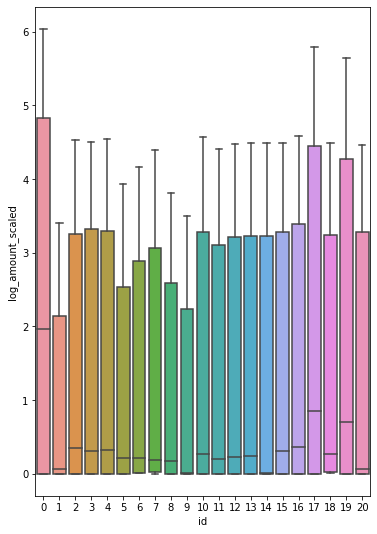

In [12]:
gens_ = gens.copy()
gens_['capacity'] = gens_['id'].apply(lambda x: capacity_mapping[x])
gens_['amount_scaled'] = gens_['amount'] / gens_['capacity']
gens_['log_amount_scaled'] = np.log1p(gens_['amount'])

plt.figure(figsize=(6, 9))
sns.boxplot(x='id', y='log_amount_scaled', data=gens_)

### 발전소별 시각화

In [138]:
gens_collected = pd.read_csv(path_gens_collected)
gens_collected['time'] = pd.to_datetime(gens_collected['time'])

start  = '2022-11-04 01:00:00+09:00'
end    = '2022-11-13 00:00:00+09:00'

t = pd.date_range(start , end, freq='1H')
t = pd.DataFrame(t)
t.columns = ['time']

df = pd.merge(t, gens_collected, on='time', how='left')
df = df.sort_values(['id', 'time']).reset_index(drop=True)
df['time'] = df['time'].astype(str)
df['time'] = df['time'].str.split("+").str[0]
df['time'] = pd.to_datetime(df['time'])
df['temp'] = df['time'] - datetime(2022,11,4,1,0,0)
df['temp'] = df['temp'].dt.total_seconds() / 60.0 / 60.0
df['temp'] = df['temp'].astype(int)

df['capacity'] = df['id'].apply(lambda x: capacity_mapping[x])
df['relative_amount'] = df['amount'] / df['capacity']

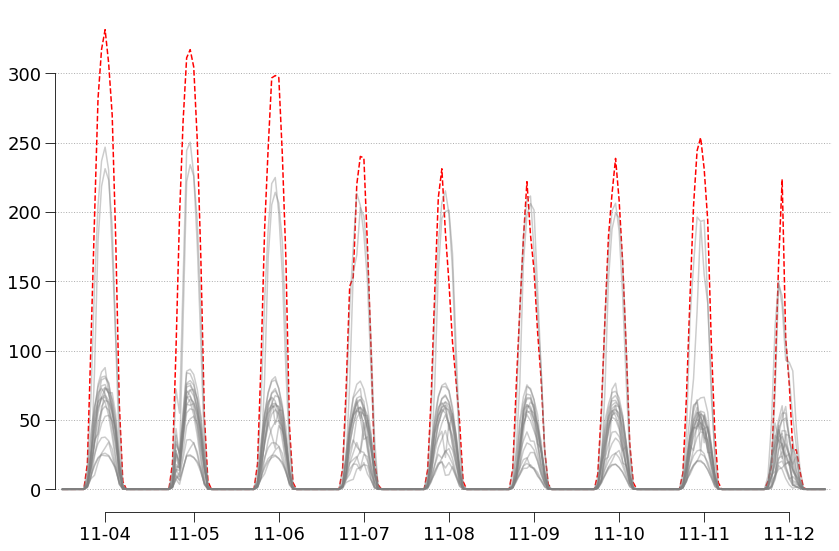

In [139]:
plt.rcParams['font.family'] = 'Helvectica'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12, 8))
for i in range(21):
    temp_df = df[df['id']== i].reset_index(drop=True)
    if i == 0:
        ax.plot(temp_df['temp'], temp_df['amount'], 'r--')
    else:
        ax.plot(temp_df['temp'], temp_df['amount'], color='gray', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines.left.set_bounds(0, 300)
ax.spines.bottom.set_bounds(12, 205)
ax.margins(x=0.01)
ax.tick_params(length=10)
plt.xticks(temp_df['temp'][12::24], [datetime.strftime(t, '%m-%d') for t in temp_df['time'][12::24]])
# ax.tick_params(length=10)
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.tight_layout()
plt.show()

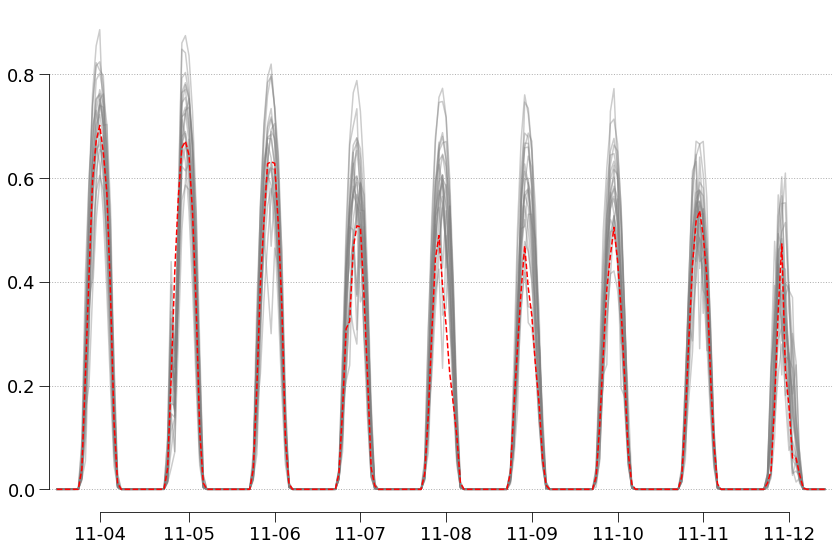

In [140]:
plt.rcParams['font.family'] = 'Helvectica'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12, 8))
for i in range(21):
    temp_df = df[df['id']== i].reset_index(drop=True)
    if i == 0:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], 'r--',zorder=3)
    else:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], color='gray', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines.left.set_bounds(0, 0.8)
# plt.ylim(0, 1)
ax.spines.bottom.set_bounds(12, 205)
ax.margins(x=0.01)
ax.tick_params(length=10)
plt.xticks(temp_df['temp'][12::24], [datetime.strftime(t, '%m-%d') for t in temp_df['time'][12::24]])
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.tight_layout()
plt.show()


In [141]:
gens_collected = pd.read_csv(os.path.join(dir_data,'gens.csv'))
gens_collected['time'] = pd.to_datetime(gens_collected['time'])

start  = '2022-10-16 01:00:00+09:00'
end    = '2022-10-22 00:00:00+09:00'

t = pd.date_range(start , end, freq='1H')
t = pd.DataFrame(t)
t.columns = ['time']

df = pd.merge(t, gens_collected, on='time', how='left')
df = df.sort_values(['id', 'time']).reset_index(drop=True)
df['time'] = df['time'].astype(str)
df['time'] = df['time'].str.split("+").str[0]
df['time'] = pd.to_datetime(df['time'])
df['temp'] = df['time'] - datetime(2022,10,16,1,0,0)
df['temp'] = df['temp'].dt.total_seconds() / 60.0 / 60.0
df['temp'] = df['temp'].astype(int)

df['capacity'] = df['id'].apply(lambda x: capacity_mapping[x])
df['relative_amount'] = df['amount'] / df['capacity']
df

,time,id,amount,temp,capacity,relative_amount
0,2022-10-16 01:00:00,0,0.0,0,472.39,0.0
1,2022-10-16 02:00:00,0,0.0,1,472.39,0.0
2,2022-10-16 03:00:00,0,0.0,2,472.39,0.0
3,2022-10-16 04:00:00,0,0.0,3,472.39,0.0
4,2022-10-16 05:00:00,0,0.0,4,472.39,0.0
...,...,...,...,...,...,...
3019,2022-10-21 20:00:00,20,0.0,139,98.60,0.0
3020,2022-10-21 21:00:00,20,0.0,140,98.60,0.0
3021,2022-10-21 22:00:00,20,0.0,141,98.60,0.0
3022,2022-10-21 23:00:00,20,0.0,142,98.60,0.0


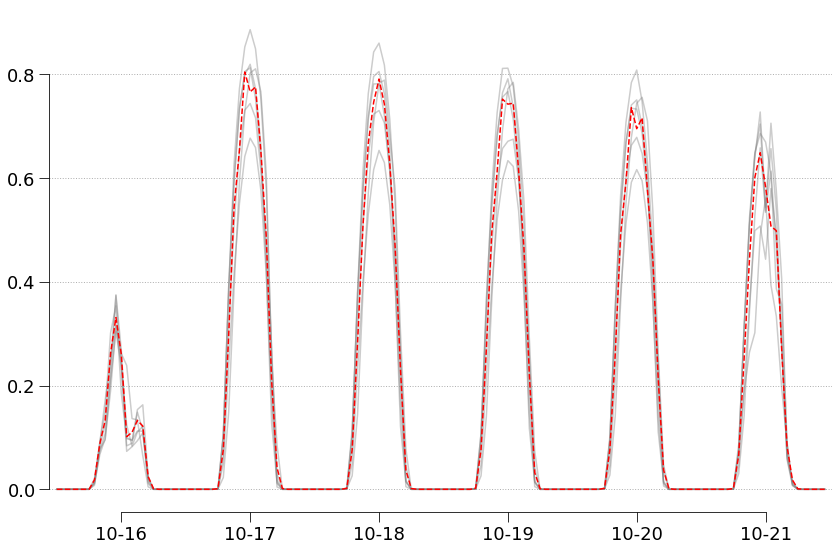

In [145]:
plt.rcParams['font.family'] = 'Helvectica'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12, 8))
for i in [0, 1, 6, 7, 8, 9, 20]:
    temp_df = df[df['id']== i].reset_index(drop=True)
    if i == 0:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], 'r--',zorder=3)
    else:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], color='gray', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines.left.set_bounds(0, 0.8)
ax.spines.bottom.set_bounds(12, 132)
ax.margins(x=0.01)
ax.tick_params(length=10)
plt.xticks(temp_df['temp'][12::24], [datetime.strftime(t, '%m-%d') for t in temp_df['time'][12::24]])
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.tight_layout()
plt.show()


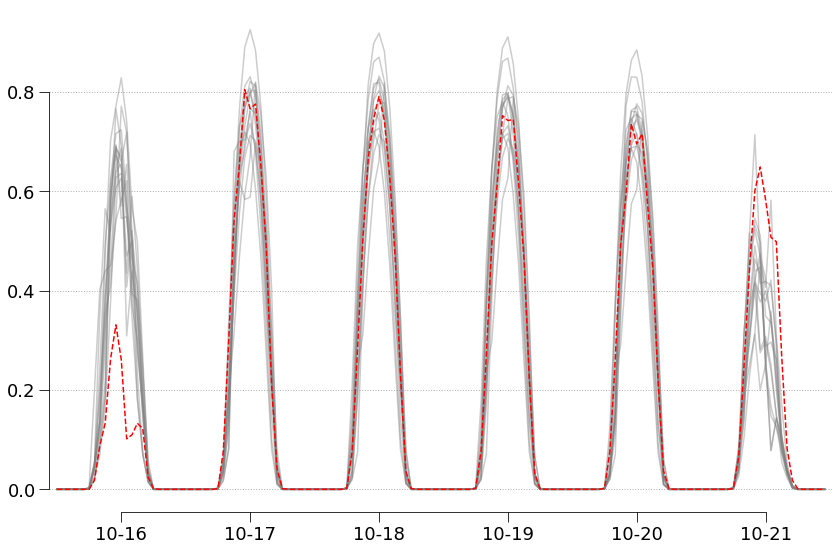

In [147]:
plt.rcParams['font.family'] = 'Helvectica'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12, 8))
for i in [0, 2, 3, 4, 5] + list(range(10, 20)):
    temp_df = df[df['id']== i].reset_index(drop=True)
    if i == 0:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], 'r--',zorder=3)
    else:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], color='gray', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines.left.set_bounds(0, 0.8)
ax.spines.bottom.set_bounds(12, 132)
ax.margins(x=0.01)
ax.tick_params(length=10)
plt.xticks(temp_df['temp'][12::24], [datetime.strftime(t, '%m-%d') for t in temp_df['time'][12::24]])
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.tight_layout()
plt.show()


In [150]:
gens_collected = pd.read_csv(os.path.join(dir_data,'gens.csv'))
gens_collected['time'] = pd.to_datetime(gens_collected['time'])

start  = '2022-8-1 01:00:00+09:00'
end    = '2022-10-1 00:00:00+09:00'

t = pd.date_range(start , end, freq='1H')
t = pd.DataFrame(t)
t.columns = ['time']

df = pd.merge(t, gens_collected, on='time', how='left')
df = df.sort_values(['id', 'time']).reset_index(drop=True)
df['time'] = df['time'].astype(str)
df['time'] = df['time'].str.split("+").str[0]
df['time'] = pd.to_datetime(df['time'])
df['temp'] = df['time'] - datetime(2022,8,1,1,0,0)
df['temp'] = df['temp'].dt.total_seconds() / 60.0 / 60.0
df['temp'] = df['temp'].astype(int)

df['capacity'] = df['id'].apply(lambda x: capacity_mapping[x])
df['relative_amount'] = df['amount'] / df['capacity']
df

,time,id,amount,temp,capacity,relative_amount
0,2022-08-01 01:00:00,0,0.0,0,472.39,0.0
1,2022-08-01 02:00:00,0,0.0,1,472.39,0.0
2,2022-08-01 03:00:00,0,0.0,2,472.39,0.0
3,2022-08-01 04:00:00,0,0.0,3,472.39,0.0
4,2022-08-01 05:00:00,0,0.0,4,472.39,0.0
...,...,...,...,...,...,...
30739,2022-09-30 20:00:00,20,0.0,1459,98.60,0.0
30740,2022-09-30 21:00:00,20,0.0,1460,98.60,0.0
30741,2022-09-30 22:00:00,20,0.0,1461,98.60,0.0
30742,2022-09-30 23:00:00,20,0.0,1462,98.60,0.0


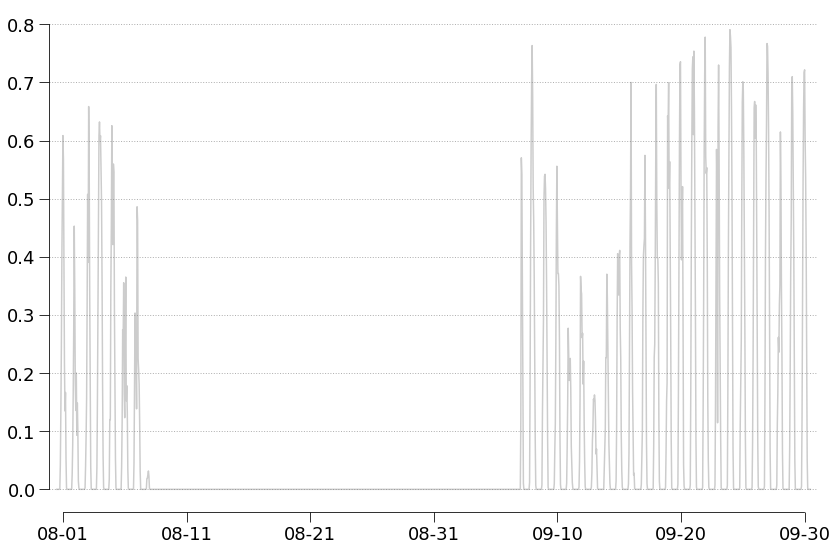

In [157]:
plt.rcParams['font.family'] = 'Helvectica'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12, 8))
for i in [9]:
    temp_df = df[df['id']== i].reset_index(drop=True)
    if i == 0:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], 'r--',zorder=3)
    else:
        ax.plot(temp_df['temp'], temp_df['relative_amount'], color='gray', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines.left.set_bounds(0, 0.8)
ax.spines.bottom.set_bounds(12, 1451)
ax.margins(x=0.01)
ax.tick_params(length=10)
plt.xticks(temp_df['temp'][12::240], [datetime.strftime(t, '%m-%d') for t in temp_df['time'][12::240]])
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.tight_layout()
plt.show()
